In [13]:
#v3.classification
#28/11/2018

dataname="trg-gray"

patch_size=64 #size of the tiles to extract and save in the database, must be >= to training size
test_set_size=.1 # what percentage of the dataset should be used as a held out validation/testing set
class_names=["Fat", "Muscular", "Vein", "Gland", "Stroma", "Tumor", "Necrosis", "Epithelium"]

resize=1
#-- relating to masks
max_number_samples={"train":100,"val":10}
phases=['train','val'] 

#-----Note---
#One should likely make sure that  (nrow+mirror_pad_size) mod patch_size == 0, where nrow is the number of rows after resizing
#so that no pixels are lost (any remainer is ignored)


In [14]:
def random_subset(a, b, nitems):
    assert len(a) == len(b)
    idx = np.random.randint(0,len(a),nitems)
    return a[idx], b[idx]

In [15]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = numpy.random.permutation(len(a))
    return a[p], b[p]

In [16]:
import sys

In [17]:
print(sys.path)

['/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '', '/home/ltran/.local/lib/python3.6/site-packages', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/home/ltran/.ipython']


In [18]:
import torch
import tables
import os,sys

import glob

import PIL
import numpy as np

import cv2
import matplotlib.pyplot as plt

import scipy.signal

from sklearn import model_selection
import sklearn.feature_extraction.image
import random

from collections import Counter


from tqdm.autonotebook import tqdm

import openslide

seed = random.randrange(sys.maxsize) #get a random seed so that we can reproducibly do the cross validation setup
random.seed(seed) # set the seed
print(f"random seed (note down for reproducibility): {seed}")

random seed (note down for reproducibility): 7005435921059200370


In [19]:
img_dtype = tables.UInt8Atom()  # dtype in which the images will be saved, this indicates that images will be saved as unsigned int 8 bit, i.e., [0,255]
filenameAtom = tables.StringAtom(itemsize=255) #create an atom to store the filename of the image, just incase we need it later, 

In [20]:
files=glob.glob('../masks4/*-mask.png')
#create training and validation stages and split the files appropriately between them
print(files[0])

../masks4/slide-2019-09-24T09-59-19-R1-S3.mrxs_Tumor_(4.00,62442,78320,7257,9303)-mask.png


In [21]:
!ls

make_hdf5-gray.ipynb		     train_smallnetwork-gray.ipynb
make_hdf5-gray.py		     train_smallnetwork-gray.py
make_output_smallnetwork-gray.ipynb  trg-gray_train.pytable
make_output_smallnetwork-gray.py     trg-gray_val.pytable
runs


In [22]:
hdf5_file.close()

In [23]:
storage={} #holder for future pytables

block_shape=np.array((patch_size,patch_size)) #block shape specifies what we'll be saving into the pytable array, here we assume that masks are 1d and images are 3d

filters=tables.Filters(complevel=6, complib='zlib') #we can also specify filters, such as compression, to improve storage speed

for phase in phases: #now for each of the phases, we'll loop through the files
    print(phase)
    
    totals=np.zeros(len(class_names)) # we can to keep counts of all the classes in for in particular training, since we 
    
    hdf5_file = tables.open_file(f"./{dataname}_{phase}.pytable", mode='w') #open the respective pytable
    storage["filenames"] = hdf5_file.create_earray(hdf5_file.root, 'filenames', filenameAtom, (0,)) #create the array for storage
    
    storage["imgs"]= hdf5_file.create_earray(hdf5_file.root, "imgs", img_dtype,  
                                              shape=np.append([0],block_shape), 
                                              chunkshape=np.append([1],block_shape),
                                              filters=filters)
    storage["labels"]= hdf5_file.create_earray(hdf5_file.root, "labels", img_dtype,  
                                              shape=[0], 
                                              chunkshape=[1],
                                              filters=filters)

    
    for fname_mask in tqdm(files): #now for each of the files
        classid=[idx for idx in range(len(class_names)) if class_names[idx] in fname_mask][0]

        img = cv2.imread(fname_mask.replace("-mask.png",".png"))
        img= cv2.resize(img,(int(img.shape[1]*resize),int(img.shape[0]*resize)))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img=np.pad(img,[(100,100),(100,100)],'reflect')
        
        mask=cv2.imread(fname_mask)
        mask=cv2.resize(mask,(int(mask.shape[1]*resize),int(mask.shape[0]*resize)))
        mask=mask[:,:,0]
        mask=np.pad(mask,[(100,100),(100,100)],'constant')

        [rs,cs]=mask.nonzero()

        [rs,cs]=random_subset(rs,cs,min(max_number_samples[phase],len(rs)))
        
        totals[classid]+=len(rs)

        for i, (r,c) in tqdm(enumerate(zip(rs,cs)),total =len(rs)):

            r=int(r)
            c=int(c)
            io = img[r-patch_size//2:r+patch_size//2,c-patch_size//2:c+patch_size//2]

            storage["imgs"].append(io[None,::])
            storage["labels"].append([int(classid)]) #add the filename to the storage array
            storage["filenames"].append([fname_mask]) #add the filename to the storage array
            
        
    #lastely, we should store the number of pixels
    for key, value in Counter(hdf5_file.root.labels[:]).items():
        totals[key]=value
    
    npixels=hdf5_file.create_carray(hdf5_file.root, 'classsizes', tables.Atom.from_dtype(totals.dtype), totals.shape)
    npixels[:]=totals
    hdf5_file.close()

train




val


In [24]:
!ls

make_hdf5-gray.ipynb		     train_smallnetwork-gray.ipynb
make_hdf5-gray.py		     train_smallnetwork-gray.py
make_output_smallnetwork-gray.ipynb  trg-gray_train.pytable
make_output_smallnetwork-gray.py     trg-gray_val.pytable
runs


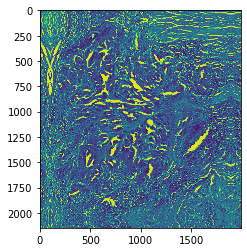

In [25]:
plt.imshow(img)

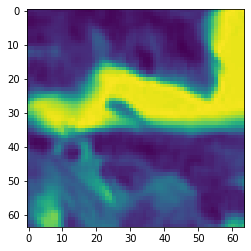

In [26]:
plt.imshow(io)